In [1]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
import matplotlib.pyplot as plt

In [2]:
import gym
import os
import numpy as np
from pyvirtualdisplay import Display
from collections import deque

from cartpole.config import get_cfg_defaults
from cartpole.utils import ReplayMemory, screen_to_state
from cartpole.model import DQN



cfg = get_cfg_defaults()

devices = ",".join(str(i) for i in cfg.SYSTEM.DEVICES)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = devices

In [3]:
"""
If you want to access the behind-the.scenes dynamics of a specific environment, 
then you use the unwrapped property.
"""
display = Display(visible=0, size=cfg.SYSTEM.VIRTUAL_SCREEN)
display.start()
env = gym.make("CartPole-v0").unwrapped


In [4]:
#policy_net = DQN(2)
#target_net = DQN(2)

In [5]:
from tensorflow.python.keras import models, layers

class Brain(models.Model):
    def __init__(self, policy_net, target_net, gamma):
        super(Brain, self).__init__()
        self.policy_net = policy_net
        self.target_net = target_net
        #self.loss_layer = LossLayer(name="TDerror")
        self.gamma = gamma
        
        self.policy_net.trainable = False
        
    def call(self, x):
        state, action, next_state, reward, done = x
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        action = tf.convert_to_tensor(action, dtype=tf.float32)
        next_state = tf.convert_to_tensor(next_state, dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        done = tf.convert_to_tensor(done, dtype=tf.float32)
        
        bz = K.shape(state)[0]
        
        q_target_next = tf.gather_nd(self.target_net(next_state), 
                                     tf.stack((tf.range(bz), 
                                              tf.cast(tf.argmax(self.policy_net(state),axis=1), dtype=tf.int32)), axis=1))
        target = reward + (self.gamma * q_target_next * (1. - done))
        estimate = tf.gather_nd(self.policy_net(state),
                                tf.stack((tf.range(bz), 
                                          tf.cast(action, dtype=tf.int32) ), axis=1))
        #loss = self.loss_layer([target, estimate])
        """
        loss = tf.keras.losses.MSE(target, estimate)
        self.add_loss(loss)
        """
        return target, estimate
    
class LossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(LossLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        loss = K.square(K.mean(inputs[0]-inputs[1]))
        self.add_loss(loss)
        return inputs

In [6]:
# agent.py
from cartpole.utils import Transition
import tensorflow as tf
from tensorflow.python.keras import backend as K
import random


class DqnAgent():
    def __init__(self, input_shape=(128, 128, 3), 
                 action_space=2, 
                 soft_update_ratio=0.01,
                 learning_rate=1e-4,
                 update_every=10,
                 gamma=0.99,
                 memory=None,
                 batch_size=128,
                 fully_random_mode=False,
                 ):
        self.action_space = action_space
        self.soft_update_ratio = soft_update_ratio
        self.gamma = gamma
        self.memory = memory
        self.batch_size = batch_size
        self.update_every = update_every
        self.fully_random_mode = fully_random_mode
        
        K.clear_session()
        self.policy_net = DQN(action_space) # action giver
        self.target_net = DQN(action_space) # action learner
        self.policy_net.build(input_shape=(1,)+input_shape)
        self.target_net.build(input_shape=(1,)+input_shape)
        self._init_weights_copy() # sync weights at begining
        
        self.brain = Brain(policy_net=self.policy_net, 
                           target_net=self.target_net, 
                           gamma=gamma)
        self.optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        
        self.step_done = 0
    
    def act(self, state, eps):
        """ Decide to random act or follow policy"""
        dice = random.random()
        if (dice < eps) or (self.fully_random_mode):
            # Random act
            action = np.random.choice(self.action_space)
        else:
            # Follow policy
            #print(state.shape)
            action = self.policy_net.predict(state[np.newaxis, :,:,:])
            action = np.argmax(action, axis=1)[0]
            #print("The action: {}".format(action))
        
        return action
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return False
        
        if (self.step_done % self.update_every) == 0:
            transition = self.memory.sample(self.batch_size)
            batch = Transition(*zip(*transition))
            batch = [np.array(batch.state, np.float32), 
                     np.array(batch.action, dtype=np.float32), 
                     np.array(batch.next_state, dtype=np.float32),
                     np.array(batch.reward, dtype=np.float32), 
                     np.array(batch.done, dtype=np.float32)]

            target, estimate = self.brain(batch)
            loss = self.compute_loss(target, estimate)

            grads = tf.gradients(loss, self.brain.trainable_variables)
            _ = self.optimizer.apply_gradients(zip(grads, self.brain.trainable_variables))
            
            self._soft_update()
            return True
    
    def _soft_update(self):
        for pl,tl in zip(self.policy_net.layers, self.target_net.layers):
            pl.set_weights([wp*self.soft_update_ratio+tp*(1.-self.soft_update_ratio) \
                            for wp,tp in zip(pl.get_weights(), tl.get_weights())])
        
    def _init_weights_copy(self):
        for pl,tl in zip(self.policy_net.layers, self.target_net.layers):
            pl.set_weights([tp for wp,tp in zip(pl.get_weights(), tl.get_weights())])

        
    @staticmethod
    def compute_loss(y_true, y_pred):
        #return K.mean(K.square(y_true-y_pred))
        return tf.keras.losses.MSE(y_true, y_pred)
        

In [7]:
memory = ReplayMemory(capacity=int(cfg.AGENT.NUM_MEMORY_CAPACITY))
agent = DqnAgent(action_space=env.action_space.n, gamma=cfg.AGENT.GAMMA, memory=memory,
                 batch_size=cfg.AGENT.BATCH_SIZE, 
                 input_shape=cfg.MODEL.INPUT_SIZE,
                 fully_random_mode=False,
                 )

W0515 22:40:57.605401 140047020975872 deprecation.py:506] From /home/seanyu/.conda/envs/pyttf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#cfg.AGENT.NUM_EPISODE
scores = []
scores_window = deque(maxlen=100)
eps = cfg.AGENT.EPS_START
for i_episode in range(100):
    env.reset()
    last_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
    current_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
    state = current_screen - last_screen
    total_rewards = 0
    for t_counter in range(cfg.AGENT.MAX_T):
        action = agent.act(state, eps)
        
        vector_state, reward, is_done, _ = env.step(action)
        total_rewards += reward
        
        last_screen = current_screen
        current_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
        if not is_done:
            next_state = current_screen - last_screen
        else:
            next_state = current_screen - current_screen
            
        memory.push(state, action, next_state, reward, is_done*1)
        state = next_state
        
        # Train the model
        agent.learn()
        
        print("\rEpisode {}, Accumulated Reward: {:.3f}, remain time: {}".format(i_episode, total_rewards, t_counter), end='')
        
        if is_done:
            break
    print("")
    scores.append(total_rewards)
    scores_window.append(total_rewards)
    eps = max(cfg.AGENT.EPS_END, eps*cfg.AGENT.EPS_DECAY)

Episode 0, Accumulated Reward: 21.000, remain time: 20
Episode 1, Accumulated Reward: 11.000, remain time: 10
Episode 2, Accumulated Reward: 11.000, remain time: 10
Episode 3, Accumulated Reward: 11.000, remain time: 10
Episode 4, Accumulated Reward: 21.000, remain time: 20
Episode 5, Accumulated Reward: 31.000, remain time: 30
Episode 6, Accumulated Reward: 11.000, remain time: 10
Episode 7, Accumulated Reward: 11.000, remain time: 10
Episode 8, Accumulated Reward: 11.000, remain time: 10
Episode 9, Accumulated Reward: 31.000, remain time: 30
Episode 10, Accumulated Reward: 11.000, remain time: 10
Episode 11, Accumulated Reward: 21.000, remain time: 20
Episode 12, Accumulated Reward: 11.000, remain time: 10
Episode 13, Accumulated Reward: 31.000, remain time: 30
Episode 14, Accumulated Reward: 1.000, remain time: 0
Episode 15, Accumulated Reward: 11.000, remain time: 10
Episode 16, Accumulated Reward: 11.000, remain time: 10
Episode 17, Accumulated Reward: 21.000, remain time: 20
Epis

In [9]:
m = agent.memory.sample(16)

ValueError: Sample larger than population or is negative

In [10]:
b = Transition(*zip(*m))
batch = [np.array(b.state, np.float32), 
         np.array(b.action, dtype=np.float32), 
         np.array(b.next_state, dtype=np.float32),
         np.array(b.reward, dtype=np.float32), 
         np.array(b.done, dtype=np.float32)]

NameError: name 'm' is not defined

In [14]:
new_brain = Brain(policy_net=agent.policy_net, target_net=agent.target_net, gamma=0.9)
optim = tf.keras.optimizers.Adam(lr=1e-3)

In [15]:
def compute_loss(y_true, y_pred):
    return K.square(K.mean(y_true-y_pred))

In [57]:
w = new_brain.policy_net.layers[0]
for pl,tl in zip(new_brain.policy_net.layers, new_brain.target_net.layers):
    #for wp, tp in zip(pl.get_weights(), tl.get_weights()):
    #    pass
    pl.set_weights([wp+tp for wp,tp in zip(pl.get_weights(), tl.get_weights())])

[array([[-0.01863667, -0.04137802],
        [-0.03106486, -0.02555148],
        [ 0.03848599,  0.02642571],
        ...,
        [-0.04084814,  0.04457727],
        [-0.0089037 , -0.00303756],
        [-0.0008429 ,  0.00597804]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [58]:
new_brain.policy_net.layers[0].get_weights()

[array([[[[-0.02575752,  0.09045018,  0.03571062, ...,  0.11524222,
           -0.04691502,  0.03928755],
          [ 0.1134754 , -0.12124689,  0.0060924 , ..., -0.15820917,
           -0.11014158, -0.12109184],
          [ 0.03262129,  0.00106931, -0.14066842, ..., -0.11396592,
            0.03360609,  0.17134659]],
 
         [[-0.07896976,  0.02046461,  0.04549459, ...,  0.15142632,
           -0.01519348,  0.01971835],
          [-0.17696282, -0.03739734, -0.11174569, ...,  0.06751206,
           -0.01951267, -0.03432895],
          [ 0.07173727,  0.06990234,  0.07825516, ..., -0.07057861,
            0.07950595, -0.08733109]],
 
         [[ 0.01736365,  0.01501661, -0.0129467 , ...,  0.13516904,
           -0.11712632, -0.01774555],
          [-0.07088996, -0.01062789, -0.06326881, ...,  0.0162526 ,
           -0.00037254, -0.14026643],
          [-0.06608269,  0.09854229, -0.20147267, ..., -0.02298888,
            0.17841053, -0.18294418]],
 
         [[ 0.15711099,  0.11948735, 

In [59]:
new_brain.target_net.layers[0].get_weights()

[array([[[[-0.05038769,  0.08415477,  0.08035409, ...,  0.10994935,
           -0.06496109,  0.06083599],
          [ 0.00859439, -0.06753028,  0.07536638, ..., -0.09180421,
           -0.03658859, -0.05217064],
          [ 0.03294705, -0.08433501, -0.08929086, ..., -0.06175764,
           -0.04547492,  0.09368724]],
 
         [[-0.10329784,  0.04270457, -0.01773503, ...,  0.10685208,
           -0.09006869, -0.06122732],
          [-0.11227836, -0.10460275, -0.02165819, ...,  0.08616321,
           -0.01971739,  0.02773802],
          [ 0.08674106,  0.0729683 ,  0.09306672, ..., -0.00423989,
            0.0375215 ,  0.00698671]],
 
         [[-0.01460491, -0.05666185, -0.09906656, ...,  0.07671502,
           -0.07882241, -0.09601937],
          [-0.02280128, -0.04941789,  0.0312103 , ...,  0.01578487,
           -0.04527259, -0.05082465],
          [ 0.0022743 ,  0.00419892, -0.10342871, ..., -0.06046363,
            0.10365131, -0.07370836]],
 
         [[ 0.04874022,  0.01000919, 

In [33]:
"""
# Not implementedError ...
with tf.GradientTape() as tape:
    target, estimate = new_brain(batch)
    loss = compute_loss(target, estimate)    
grads = tape.gradient(loss, new_brain.trainable_variables)
"""


'\n# Not implementedError ...\nwith tf.GradientTape() as tape:\n    target, estimate = new_brain(batch)\n    loss = compute_loss(target, estimate)    \ngrads = tape.gradient(loss, new_brain.trainable_variables)\n'

In [14]:
target, estimate = new_brain(batch)
loss = compute_loss(target, estimate)

In [15]:
grads = tf.gradients(loss, new_brain.trainable_variables)
_ = optim.apply_gradients(zip(grads, new_brain.trainable_variables))

In [25]:
new_brain.losses

[]

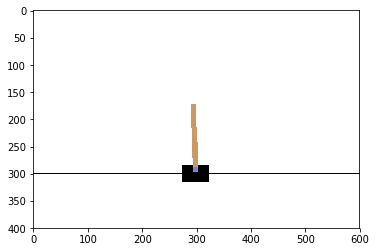

In [47]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.show()

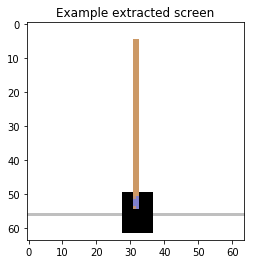

In [8]:
env.reset()
plt.figure()
plt.imshow(screen_to_state(env))
plt.title('Example extracted screen')
plt.show()

In [22]:
for i in range(100):
    print("\r{}".format(i), end='')

99